# Quora QQP

### Bag of Words (Count Vectorizer )

#### Performance Metrics

- Log Loss 
- Binary Confusion Matrix


- SGDClassifier
- XGBoost

In [1]:
# importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss

from scipy.sparse import hstack
from xgboost import XGBClassifier

In [2]:
# importing the preprocessed dataset

df = pd.read_pickle("./questions_preprocessed.pkl")

In [3]:
df.head(10)

,question1,question2,is_duplicate,q1_len,q2_len,q1_word_len,q2_word_len,q1_char_len,q2_char_len,len_diff,word_len_diff,char_len_diff,common_words,common_words_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,step step guide invest share market india,step step guide invest share market,0,66,57,14,12,53,46,9,2,7,10,0.384615,92,100,92,100
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,51,88,8,13,44,76,37,5,32,4,0.190476,59,94,59,84
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,73,59,14,10,60,50,14,4,10,4,0.166667,55,56,70,70
3,mentally lonely solve,find remainder math2324math divided 2423,0,50,65,11,9,40,57,15,2,17,0,0.000000,23,29,23,23
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,76,39,13,7,64,33,37,6,31,2,0.100000,43,52,40,51
5,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1,86,90,16,16,71,75,4,0,4,8,0.250000,64,65,60,69
6,buy tiago,keeps childern active far phone video games,0,19,62,4,11,16,52,43,7,36,0,0.000000,19,33,19,19
7,good geologist,great geologist,1,30,41,7,9,24,33,11,2,9,4,0.250000,76,71,76,78
8,use shi instead shi,use instead,0,31,37,8,8,24,30,6,0,6,6,0.375000,73,82,73,100
9,motorola company hack charter motorolla dcx3400,hack motorola dcx3400 free internet,0,60,49,9,9,52,41,11,0,11,3,0.166667,51,60,59,75


In [4]:
# creating a single list of unique questions

uniq_questions = pd.concat((df['question1'], df['question2'])).unique()   

In [5]:
# applying count vectorizer

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(uniq_questions)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
                vocabulary=None)

In [6]:
# transform question1 and question2 using count vectorizer

question1_vect = count_vect.transform(df['question1'])
question2_vect = count_vect.transform(df['question2'])

In [7]:
# list all column names

print(df.columns)

Index(['question1', 'question2', 'is_duplicate', 'q1_len', 'q2_len',
       'q1_word_len', 'q2_word_len', 'q1_char_len', 'q2_char_len', 'len_diff',
       'word_len_diff', 'char_len_diff', 'common_words', 'common_words_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio',
       'token_set_ratio'],
      dtype='object')


The following features are available for building the model:

- question1
- question2
- q1_len
- q2_len
- q1_word_len
- q1_word_len
- q1_char_len
- q1_char_len
- len_diff
- word_len_diff
- char_len_diff
- common_words
- common_words_ratio
- fuzz_ratio
- fuzz_partial_ratio
- token_sort_ratio
- token_set_ratio

In [8]:
# all features
X = hstack((question1_vect, question2_vect, df[['q1_len','q2_len','q1_word_len','q1_word_len','q1_char_len','q1_char_len','len_diff','word_len_diff','char_len_diff','common_words','common_words_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio']]))

# output feature: is_duplicate
y = df['is_duplicate']

In [9]:
# splitting the training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# plotting the confusion matrix

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".0f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

### SGDClassifier

We iterate through different alpha values to record their respective log losses. Nonetheless, a more efficient approach is employing GridSearchCV, which helps identify the optimal estimator for the SGDClassifier by focusing solely on tuning the alpha parameter.

In [11]:
start = datetime.utcnow()
alpha = [10 ** x for x in range(-5, 2)]

log_loss_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)
    log_loss_array.append(log_loss(y_test, y_pred_prob, labels=clf.classes_))
    print("For alpha={}, log loss is {}".format(i, log_loss_array[-1]))

print("Total running time: {}".format(datetime.utcnow() - start))

For alpha=1e-05, log loss is 1.9632340451732695
For alpha=0.0001, log loss is 0.8005576997880052
For alpha=0.001, log loss is 0.4750258035940437
For alpha=0.01, log loss is 0.5895692439526894
For alpha=0.1, log loss is 0.5555231636538255
For alpha=1, log loss is 0.5698953927695427
For alpha=10, log loss is 0.587482908170217
Total running time: 0:02:24.571748


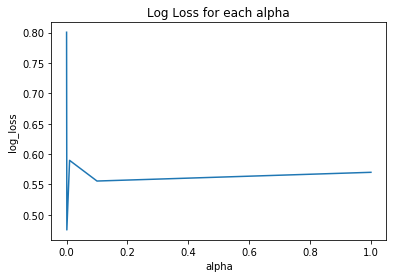

In [12]:
data_plot = pd.DataFrame(
    {"alpha": alpha[1:-1], "log_loss": log_loss_array[1:-1]})
sns.lineplot(x="alpha", y="log_loss", data=data_plot)
plt.title('Log Loss for each alpha')
plt.show()

In [13]:
clf = SGDClassifier(alpha=0.001, penalty='l2', loss='log', n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

Log Loss (Training): 0.4774020528995281

Log Loss (Testing): 0.4750258035940437

Accuracy Score: 0.7495981204402127

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.87      0.81     51240
           1       0.70      0.55      0.61     29630

    accuracy                           0.75     80870
   macro avg       0.74      0.71      0.71     80870
weighted avg       0.74      0.75      0.74     80870


Confustion Matrix: 



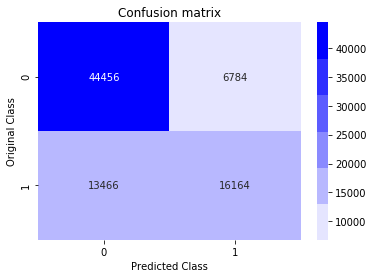

In [14]:
print("Log Loss (Training): {}\n".format(log_loss(y_train, clf.predict_proba(X_train))))
print("Log Loss (Testing): {}\n".format(log_loss(y_test, y_pred_prob, labels=clf.classes_)))
print("Accuracy Score: {}\n".format(accuracy_score(y_test, y_pred)))
print('Classification Report:\n')
print(classification_report(y_test, y_pred))
print('\nConfustion Matrix: \n')
plot_confusion_matrix(y_test, y_pred)

### XGBClassifier 


In [15]:
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_jobs=-1, random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_prob = xgb_clf.predict_proba(X_test)
y_pred = xgb_clf.predict(X_test)

In [ ]:
print("Log Loss (Training): {}\n".format(log_loss(y_train, xgb_clf.predict_proba(X_train))))
print("Log Loss (Testing): {}\n".format(log_loss(y_test, y_pred_prob, labels=clf.classes_)))
print("Accuracy Score: {}\n".format(accuracy_score(y_test, y_pred)))
print('Classification Report:\n')
print(classification_report(y_test, y_pred))
print('\nConfustion Matrix: \n')
plot_confusion_matrix(y_test, y_pred)